In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.spatial.distance import cdist
import joblib

In [72]:
data = pd.read_csv('cleaned_property_data.csv')

In [73]:
categorical_features = ['TYPE', 'ZIPCODE', 'BOROUGH']
numeric_features = ['BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE']

X = data[categorical_features + numeric_features]
y = data['PRICE']

In [74]:
# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [75]:
# Create a pipeline with preprocessor and model
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [76]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['BEDS', 'BATH',
                                                   'PROPERTYSQFT', 'LATITUDE',
                                                   'LONGITUDE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TYPE', 'ZIPCODE',
                                                   'BOROUGH'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [77]:
# Calculate performance metrics
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate MAE as a percentage
avg_train_price = y_train.mean()
avg_test_price = y_test.mean()
train_mae_percent = (train_mae / avg_train_price) * 100
test_mae_percent = (test_mae / avg_test_price) * 100

print("Model Performance:")
print(f"Training R2 Score: {train_r2:.4f}")
print(f"Testing R2 Score: {test_r2:.4f}")
print(f"Training MAE: ${train_mae:,.2f} ({train_mae_percent:.2f}%)")
print(f"Testing MAE: ${test_mae:,.2f} ({test_mae_percent:.2f}%)")

Model Performance:
Training R2 Score: 0.9678
Testing R2 Score: 0.6773
Training MAE: $69,150.76 (7.73%)
Testing MAE: $208,789.67 (23.13%)


In [78]:
# Save the model
joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

In [79]:
# Create a pipeline with preprocessor and model
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [80]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
# Calculate performance metrics
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate MAE as a percentage
avg_train_price = y_train.mean()
avg_test_price = y_test.mean()
train_mae_percent = (train_mae / avg_train_price) * 100
test_mae_percent = (test_mae / avg_test_price) * 100

print("Model Performance:")
print(f"Training R2 Score: {train_r2:.4f}")
print(f"Testing R2 Score: {test_r2:.4f}")
print(f"Training MAE: ${train_mae:,.2f} ({train_mae_percent:.2f}%)")
print(f"Testing MAE: ${test_mae:,.2f} ({test_mae_percent:.2f}%)")

Model Performance:
Training R2 Score: 0.9674
Testing R2 Score: 0.6829
Training MAE: $69,668.17 (7.79%)
Testing MAE: $206,887.45 (22.92%)


In [ ]:
joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores)}")

Cross-Validation R2 Scores: [0.66897283 0.7561296  0.73763221 0.76473285 0.74459053]
Mean CV R2 Score: 0.7344116063272905


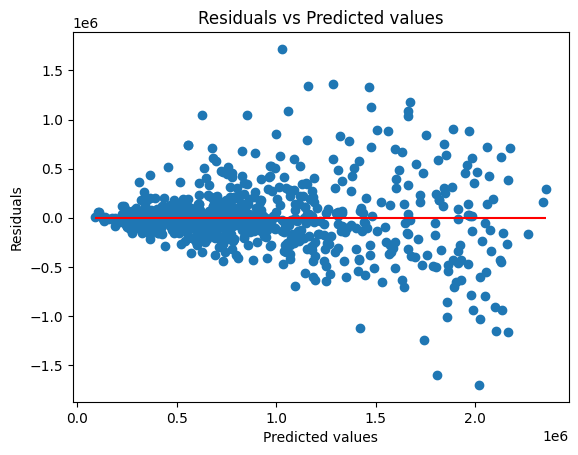

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='r')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

In [ ]:
# Get feature names for categorical features
categorical_feature_names = rf_model.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)

# Combine categorical and numerical feature names
all_feature_names = list(categorical_feature_names) + numeric_features

# Ensure the length matches the number of features in the model
assert len(all_feature_names) == len(importances), "Feature names and importances lengths do not match."

# Create a Series for feature importances
feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

NameError: name 'importances' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression

baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

baseline_model.fit(X_train, y_train)
y_test_baseline_pred = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, y_test_baseline_pred)
print(f"Baseline Linear Regression R2 Score: {baseline_r2:.4f}")


Baseline Linear Regression R2 Score: 0.5944
